In [2]:
# PARAMETERS SET BY USER
machine_name = 'EAST'
xcor = 'RZPhi' # 'RZPhi' or 'STETPhi'
if xcor == 'STETPhi': equilib = '73999_030400ms.mat'
fcor = 'RZPhi'
equilib = '73999_030400ms.mat' # input('equilib?') + ".mat"

In [3]:
from os import sys, path
sys.path.append(path.dirname(path.abspath(path.abspath(''))))
import ergospy.file 
path_machine = ergospy.file.PathMachine(machine_name)
equili_dict = ergospy.file.EquiliDictRead(machine_name, equilib)

S, TET = equili_dict['S'][:,0], equili_dict['TET'][:,0]
Q = equili_dict['Q'][:,0]
r_mesh, z_mesh = equili_dict['r_mesh'], equili_dict['z_mesh']

RM, BM, B0 = equili_dict['RM'][0,0], equili_dict['BM'][0,0], equili_dict['B0']
ASPI = equili_dict['ASPI'][0,0]
G11 = equili_dict['G11']
b3 = equili_dict['b3']

In [4]:
import progressbar, sys
from multiprocessing import Pool
from multiprocessing.sharedctypes import Value

_, coil_info = ergospy.file.CoilRead(machine_name, only_info=True)


In [5]:
from ergospy.field.Field import Field3D

def CoilParallableLoad(coilsys:str, coil:str):
    path_field_computation = path_machine / coilsys /'field_computation' 
    path_field_single = path_field_computation / coil 
    param = ergospy.file.FieldMeshRead(path_field_single, xcor=xcor, fcor=fcor)
    field = ergospy.file.FieldRead(path_field_single, xcor=xcor, fcor=fcor)
    return Field3D(param['R'], param['Z'], param['Phi'],
                   field[...,0], field[...,1], field[...,2]).xcor_RZ2STET(S,TET, r_mesh,z_mesh).fourier_Phi2N()

proc_pool = Pool(); print(f"Parallelly reading fields...")
field_read_dict = {}
for coilsys in coil_info.keys():
    field_read_dict[coilsys] = {}
    for i, coil in enumerate(coil_info[coilsys].keys()):
        field_read_dict[coilsys][coil] = proc_pool.apply_async(CoilParallableLoad, args=([coilsys, coil]) )

field3d_dict = {}
for coilsys in coil_info.keys():
    field3d_dict[coilsys] = {}
    for i, coil in enumerate(coil_info[coilsys].keys()):
        field3d_dict[coilsys][coil] = field_read_dict[coilsys][coil].get()
        
field3d_eg = field3d_dict[coilsys][coil].zeros_like()
proc_pool.close(); proc_pool.join(); print(f"Fields reading has been done.")

Parallelly reading fields...
Fields reading has been done.


In [60]:
import pandas as pd
import numpy as np
work_mode_setup_df = pd.DataFrame(
    columns =  ["Machine", "Coilsys", "Recipe Name", 
                "Amp List", "Rot List", 'Main n', 'Main m', 'Tor Ang', 'Amp Phase0',"Amp Phase"])

work_mode_setup_df = work_mode_setup_df.append({
    'Machine':machine_name, 'Coilsys':'HCFs', 'Recipe Name':'uniform', 
    'Amp List':[0.2]*5}, ignore_index=True)

work_mode_setup_df = work_mode_setup_df.append({
    'Machine':machine_name, 'Coilsys':'high_m_coils', 'Recipe Name':'primary', 
    'Amp List':[1.0,-1.0]}, ignore_index=True)
work_mode_setup_df = work_mode_setup_df.append({
    'Machine':machine_name, 'Coilsys':'high_m_coils', 'Recipe Name':'secondary', 
    'Amp List':[1.0,+1.0]}, ignore_index=True)

tor_ang = [float(i)*np.pi/4 for i in list(range(0,8))]*2
# for main_n in [1,2]:
#     amp_phase0 = [0.0]*8 + [0.0]*8
#     work_mode_setup_df = work_mode_setup_df.append({
#         'Machine':machine_name, 'Coilsys':'low_n_coils', 'Recipe Name':f'even_n_is_{main_n}', 
#         'Tor Ang': tor_ang, 'Amp List':[1.0]*8+[1.0]*8, 'Main n': main_n, 'Amp Phase0':amp_phase0, 
#         'Amp Phase':[main_n*tor_ang[i]-amp_phase0[i] for i in range(16)]}, ignore_index=True)
#     amp_phase0 = [0.0]*8 + [np.pi]*8
#     work_mode_setup_df = work_mode_setup_df.append({
#         'Machine':machine_name, 'Coilsys':'low_n_coils', 'Recipe Name':f'odd_n_is_{main_n}', 
#         'Tor Ang': tor_ang, 'Amp List':[1.0]*8+[1.0]*8, 'Main n': main_n, 'Amp Phase0':amp_phase0, 
#         'Amp Phase':[main_n*tor_ang[i]-amp_phase0[i] for i in range(16)]}, ignore_index=True)
main_n = 4
# for amp in np.linspace(1.0, 10.0, 10):
amp = 10.0
for amp_phase_UP in np.linspace(0.0, 2*np.pi, 20):
    for amp_phase_DOWN in np.linspace(0.0, 2*np.pi, 20):
        amp_phase0 = [amp_phase_UP]*8 + [amp_phase_DOWN]*8
        work_mode_setup_df = work_mode_setup_df.append({
            'Machine':machine_name, 'Coilsys':'low_n_coils', 'Recipe Name':f'n_is_{main_n}', 
            'Tor Ang': tor_ang, 'Amp List':[amp]*8+[amp]*8, 'Main n': main_n, 'Amp Phase0':amp_phase0, 
            'Amp Phase':[main_n*tor_ang[i]-amp_phase0[i] for i in range(16)]}, ignore_index=True)

In [61]:
work_mode_setup_df

Machine       Coilsys Recipe Name  \
0      EAST          HCFs     uniform   
1      EAST  high_m_coils     primary   
2      EAST  high_m_coils   secondary   
3      EAST   low_n_coils      n_is_4   
4      EAST   low_n_coils      n_is_4   
..      ...           ...         ...   
398    EAST   low_n_coils      n_is_4   
399    EAST   low_n_coils      n_is_4   
400    EAST   low_n_coils      n_is_4   
401    EAST   low_n_coils      n_is_4   
402    EAST   low_n_coils      n_is_4   

                                              Amp List Rot List Main n Main m  \
0                            [0.2, 0.2, 0.2, 0.2, 0.2]      NaN    NaN    NaN   
1                                          [1.0, -1.0]      NaN    NaN    NaN   
2                                           [1.0, 1.0]      NaN    NaN    NaN   
3    [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....      NaN      4    NaN   
4    [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....      NaN      4    NaN   
..                                                 ...      ...    ...    ...   
398  [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....      NaN      4    NaN   
399  [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....      NaN      4    NaN   
400  [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....      NaN      4    NaN   
401  [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....      NaN      4    NaN   
402  [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....      NaN      4    NaN   

                                               Tor Ang  \
0                                                  NaN   
1                                                  NaN   
2                                                  NaN   
3    [0.0, 0.7853981633974483, 1.5707963267948966, ...   
4    [0.0, 0.7853981633974483, 1.5707963267948966, ...   
..                                                 ...   
398  [0.0, 0.7853981633974483, 1.5707963267948966, ...   
399  [0.0, 0.7853981633974483, 1.5707963267948966, ...   
400  [0.0, 0.7853981633974483, 1.5707963267948966, ...   
401  [0.0, 0.7853981633974483, 1.5707963267948966, ...   
402  [0.0, 0.7853981633974483, 1.5707963267948966, ...   

                                            Amp Phase0  \
0                                                  NaN   
1                                                  NaN   
2                                                  NaN   
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.330...   
..                                                 ...   
398  [6.283185307179586, 6.283185307179586, 6.28318...   
399  [6.283185307179586, 6.283185307179586, 6.28318...   
400  [6.283185307179586, 6.283185307179586, 6.28318...   
401  [6.283185307179586, 6.283185307179586, 6.28318...   
402  [6.283185307179586, 6.283185307179586, 6.28318...   

                                             Amp Phase  
0                                                  NaN  
1                                                  NaN  
2                                                  NaN  
3    [0.0, 3.141592653589793, 6.283185307179586, 9....  
4    [0.0, 3.141592653589793, 6.283185307179586, 9....  
..                                                 ...  
398  [-6.283185307179586, -3.141592653589793, 0.0, ...  
399  [-6.283185307179586, -3.141592653589793, 0.0, ...  
400  [-6.283185307179586, -3.141592653589793, 0.0, ...  
401  [-6.283185307179586, -3.141592653589793, 0.0, ...  
402  [-6.283185307179586, -3.141592653589793, 0.0, ...  

[403 rows x 10 columns]

In [62]:
from ergospy.analysis import RMP_prof

def field3d_from_setup(setup_series):
    coilsys = setup_series['Coilsys']
    coil = list(coil_info[coilsys].keys())[0]
    BR = np.zeros_like(field3d_dict[coilsys][coil].BR)
    BZ = np.zeros_like(field3d_dict[coilsys][coil].BR)
    BPhi=np.zeros_like(field3d_dict[coilsys][coil].BR)
    for i, coil in enumerate(coil_info[coilsys].keys()):
        if setup_series['Amp List'][i]!=0.0:
            factor = setup_series['Amp List'][i]
        else: 
            continue
        try: 
            if not pd.isna(setup_series.loc['Amp Phase'])[i]:
                factor*= np.cos(setup_series.loc['Amp Phase'][i])
        except: pass
#         try:
#             if not pd.isna(setup_series.loc['Rot List'])[i]:
#                 shift = np.argmin( np.abs(field3d_dict[coilsys][coil].Phi - setup_series.loc['Rot List'][i] ))
#         except: shift = 0
#         BR += factor * np.roll( field3d_smn_dict[coilsys][coil].BR, shift, axis=2)
#         BZ += factor * np.roll( field3d_smn_dict[coilsys][coil].BZ, shift, axis=2)
#         BPhi += factor * np.roll( field3d_smn_dict[coilsys][coil].BPhi, shift, axis=2)
        BR += factor * field3d_dict[coilsys][coil].BR 
        BZ += factor * field3d_dict[coilsys][coil].BZ 
        BPhi += factor * field3d_dict[coilsys][coil].BPhi 

    return Field3D(
        S,TET, field3d_dict[coilsys][coil].N(), 
        BR, BZ, BPhi, xcor='STETN', 
        r_mesh=field3d_dict[coilsys][coil].r_mesh,
        z_mesh=field3d_dict[coilsys][coil].z_mesh, fcor='RZPhi')

HCFs_work_mode = work_mode_setup_df[
    (work_mode_setup_df['Coilsys']=='HCFs') &\
    (work_mode_setup_df['Recipe Name']=='uniform')].iloc[0]
base_field3d = field3d_from_setup(HCFs_work_mode)

def FoM(setup_series):
    field3d = field3d_from_setup(setup_series) # + base_field3d 
    chirikov_prof_multin = RMP_prof.chirikov_prof(S, Q, field3d.get_tilde_b1_mn(BM,RM, b3,B0))
    return RMP_prof.merit_evaluate_multin(chirikov_prof_multin, S, field3d.get_br_mn(BM,RM, G11))

Phi12_FoM_list = []
proc_pool, proc_list = Pool(), []; print(f"Parallelly calculating the FoMs...")
for _,setup_series in work_mode_setup_df[
    (work_mode_setup_df['Coilsys']=='low_n_coils')].iterrows():
    proc_list.append( proc_pool.apply_async(FoM, args=([setup_series]) ))
proc_num, proc_ind = len(proc_list), 0
with progressbar.ProgressBar(max_value=proc_num) as bar:
    for i,setup_series in work_mode_setup_df[
        (work_mode_setup_df['Coilsys']=='low_n_coils')].iterrows():
        Phi12_FoM_list.append([
            setup_series['Amp Phase0'][0], 
            setup_series['Amp Phase0'][-1], 
            setup_series['Amp List'][0],
            proc_list[proc_ind].get()])
        bar.update(proc_ind)
        proc_ind += 1
proc_pool.close(); proc_pool.join(); print(f"Fields calculation done.")

# for _,setup_series in progressbar.progressbar(work_mode_setup_df[
#     (work_mode_setup_df['Coilsys']=='low_n_coils')].iterrows()):
# #     field3d = base_field3d + field3d_from_setup(setup_series)
#     field3d = field3d_from_setup(setup_series)
#     chirikov_prof_multin = RMP_prof.chirikov_prof(S, Q, field3d.get_tilde_b1_mn(BM,RM, b3,B0))
#     FoM = RMP_prof.merit_evaluate_multin(chirikov_prof_multin, S, field3d.get_br_mn(BM,RM, G11))
#     Phi12_FoM_list.append([setup_series['Amp Phase0'][0], setup_series['Amp Phase0'][-1], FoM])

Parallelly calculating the FoMs...


100% (400 of 400) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Fields calculation done.


In [63]:
Phi12_FoM_arr = np.asarray(Phi12_FoM_list)
print(Phi12_FoM_arr)

import plotly.graph_objects as go
# k = 1
# i_range = list(range((k-1)*400, k*400)) 
# fig = go.Figure(data=[go.Scatter3d(
#     x=Phi12_FoM_arr[i_range,0],
#     y=Phi12_FoM_arr[i_range,1],
#     z=Phi12_FoM_arr[i_range,3],
# #     x=Phi12_FoM_arr[:,0],
# #     y=Phi12_FoM_arr[:,1],
# #     z=Phi12_FoM_arr[:,3],
#     mode='markers',
#     marker=dict(
#         size=3,
#         color=Phi12_FoM_arr[i_range,3],  # set color to an array/list of desired values
#         colorscale='Viridis',   # choose a colorscale
#         opacity=0.5
#     ))])


data = []
cmin, cmax = np.min(Phi12_FoM_arr[:,3]), np.max(Phi12_FoM_arr[:,3])
# for k in range(10,11):
#     i_range = range((k-1)*400, k*400)
#     showscale = True if k==10 else False
#     data.append(go.Surface(
#         x=Phi12_FoM_arr[i_range,0].reshape(20,20), 
#         y=Phi12_FoM_arr[i_range,1].reshape(20,20), 
#         z=Phi12_FoM_arr[i_range,3].reshape(20,20),# Phi12_FoM_arr[i_range,2].reshape(20,20) + , 
#         surfacecolor=Phi12_FoM_arr[i_range,3].reshape(20,20),showscale=showscale,
#         cmin=cmin,cmax=cmax))
data.append(go.Surface(
    x=Phi12_FoM_arr[:,0].reshape(20,20), 
    y=Phi12_FoM_arr[:,1].reshape(20,20), 
    z=Phi12_FoM_arr[:,3].reshape(20,20),# Phi12_FoM_arr[i_range,2].reshape(20,20) + , 
    surfacecolor=Phi12_FoM_arr[:,3].reshape(20,20),showscale=showscale,
    cmin=cmin,cmax=cmax))
    
fig = go.Figure(data=data)
# for k in range(1, 11):
#     i_range = list(range((k-1)*400, k*400)) 

# # fig = make_subplots(rows=1, cols=1,
# #                     specs=[[{'is_3d': True}, {'is_3d': True}]],
# #                     subplot_titles=['Color corresponds to z', 'Color corresponds to distance to origin'],
# #                     )

#     fig.add_trace(go.Surface(
#         x=Phi12_FoM_arr[i_range,0].reshape(20,20), 
#         y=Phi12_FoM_arr[i_range,1].reshape(20,20), 
#         z=Phi12_FoM_arr[i_range,2].reshape(20,20), 
#         surfacecolor=Phi12_FoM_arr[i_range,3].reshape(20,20)))
    
# fig.update_layout(title_text="Ring cyclide")
fig.show()

# tight layout
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# fig.show()

[[ 0.          0.         10.          0.02950844]
 [ 0.          0.33069396 10.          0.02902977]
 [ 0.          0.66138793 10.          0.02762462]
 ...
 [ 6.28318531  5.62179738 10.          0.02762462]
 [ 6.28318531  5.95249134 10.          0.02902977]
 [ 6.28318531  6.28318531 10.          0.02950844]]


<IPython.core.display.Javascript object>


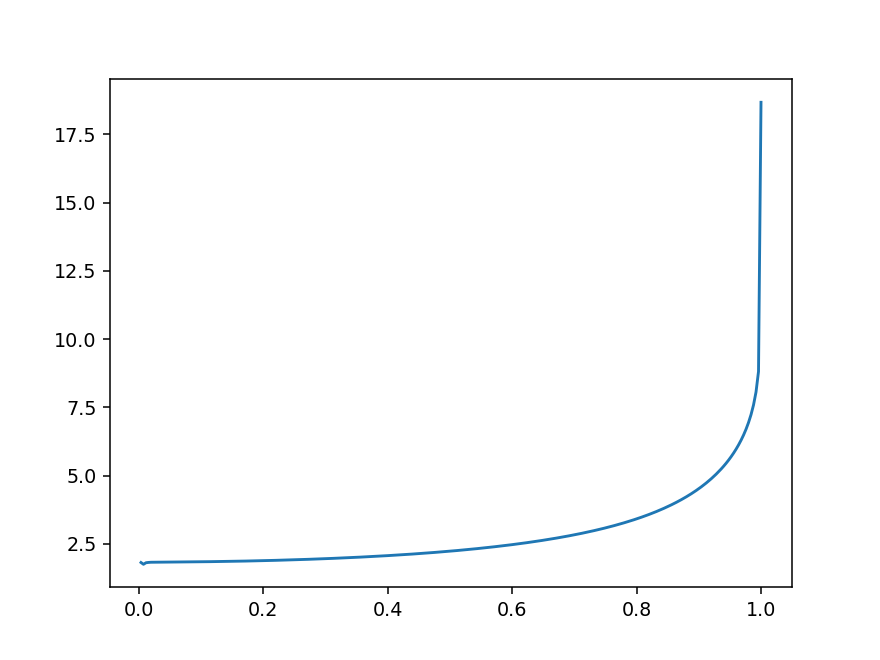

In [31]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.plot(S,Q)

## Backup
The following code is too time-consuming because we work on the xcor RZPhi directly, but beginners would be happy to understand it first.

In [ ]:
from ergospy.analysis import RMP_prof

def field3d_from_setup(setup_series):
    coilsys = setup_series['Coilsys']
    coil = list(coil_info[coilsys].keys())[0]
    BR = np.zeros_like(field3d_dict[coilsys][coil].BR)
    BZ = np.zeros_like(field3d_dict[coilsys][coil].BR)
    BPhi=np.zeros_like(field3d_dict[coilsys][coil].BR)
    for i, coil in enumerate(coil_info[coilsys].keys()):
        if setup_series['Amp List'][i]!=0.0:
            factor = setup_series['Amp List'][i]
        else: 
            continue
        try: 
            if not pd.isna(setup_series.loc['Amp Phase'])[i]:
                factor*= np.cos(setup_series.loc['Amp Phase'][i])
        except: pass
        try:
            if not pd.isna(setup_series.loc['Rot List'])[i]:
                shift = np.argmin( np.abs(field3d_dict[coilsys][coil].Phi - setup_series.loc['Rot List'][i] ))
        except: shift = 0
        BR += factor * np.roll( field3d_dict[coilsys][coil].BR, shift, axis=2)
        BZ += factor * np.roll( field3d_dict[coilsys][coil].BZ, shift, axis=2)
        BPhi += factor * np.roll( field3d_dict[coilsys][coil].BPhi, shift, axis=2)
    return Field3D(
        field3d_dict[coilsys][coil].R, 
        field3d_dict[coilsys][coil].Z, 
        field3d_dict[coilsys][coil].Phi, 
        BR, BZ, BPhi)

HCFs_work_mode = work_mode_setup_df[
    (work_mode_setup_df['Coilsys']=='HCFs') &\
    (work_mode_setup_df['Recipe Name']=='uniform')].iloc[0]
base_field3d = field3d_from_setup(HCFs_work_mode)

Phi12_FoM_list = []
# while True:
for _,setup_series in progressbar.progressbar(work_mode_setup_df[
    (work_mode_setup_df['Coilsys']=='low_n_coils')].iterrows()):
    field3d = base_field3d + field3d_from_setup(setup_series)
    field3d_STETPhi = field3d.xcor_RZ2STET(S,TET, r_mesh,z_mesh)
    chirikov_prof_multin = RMP_prof.chirikov_prof(S, Q, field3d_STETPhi.get_tilde_b1_mn(BM,RM, b3,B0))
    FoM = RMP_prof.merit_evaluate_multin(chirikov_prof_multin, S, field3d_STETPhi.get_br_mn(BM,RM, G11))
    Phi12_FoM_list.append([setup_series['Amp Phase0'][0], setup_series['Amp Phase0'][-1], FoM])